# COCO Detection (SSD MobileNet v2) with TensorFlow

We are going to use pretrained models in this notebook to show how you can do inference on them of unseen images. The pretrained models can be found here: https://www.kaggle.com/bouweceunen/pretrained-trt-engines-cocotacohardhatposenet

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import os

In [2]:
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

Cloning into 'models'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 48206 (delta 13), reused 20 (delta 1), pack-reused 48174
Receiving objects: 100% (48206/48206), 552.13 MiB | 30.91 MiB/s, done.
Resolving deltas: 100% (33233/33233), done.
Processing /kaggle/working/models/research
     |████████████████████████████████| 8.7 MB 5.8 MB/s 
     |████████████████████████████████| 89 kB 4.0 MB/s 
     |████████████████████████████████| 151 kB 11.4 MB/s 
     |████████████████████████████████| 2.0 MB 11.4 MB/s 
     |████████████████████████████████| 41 kB 452 kB/s 
     |████████████████████████████████| 56 kB 2.4 MB/s 
     |████████████████████████████████| 61 kB 4.1 MB/s 
     |████████████████████████████████| 840 kB 14.0 MB/s 
     |████████████████████████████████| 46 kB 2.2 MB/s 
     |████████████████████████████████| 95 kB 3.2 MB/s 
     |████████████████████████████████| 172 k

In [3]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [4]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [5]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=5)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

# Create LabelMap

First we need to create the label map. In this case it already exists in the TensorFlow Model Zoo repository we cloned earlier.

In [6]:
NCLASSES = 60
LABEL_MAP_PATH = './models/research/object_detection/data/mscoco_label_map.pbtxt'

In [7]:
with open(LABEL_MAP_PATH) as f:
    pprint.pprint(f.readlines())

['item {\n',
 '  name: "/m/01g317"\n',
 '  id: 1\n',
 '  display_name: "person"\n',
 '}\n',
 'item {\n',
 '  name: "/m/0199g"\n',
 '  id: 2\n',
 '  display_name: "bicycle"\n',
 '}\n',
 'item {\n',
 '  name: "/m/0k4j"\n',
 '  id: 3\n',
 '  display_name: "car"\n',
 '}\n',
 'item {\n',
 '  name: "/m/04_sv"\n',
 '  id: 4\n',
 '  display_name: "motorcycle"\n',
 '}\n',
 'item {\n',
 '  name: "/m/05czz6l"\n',
 '  id: 5\n',
 '  display_name: "airplane"\n',
 '}\n',
 'item {\n',
 '  name: "/m/01bjv"\n',
 '  id: 6\n',
 '  display_name: "bus"\n',
 '}\n',
 'item {\n',
 '  name: "/m/07jdr"\n',
 '  id: 7\n',
 '  display_name: "train"\n',
 '}\n',
 'item {\n',
 '  name: "/m/07r04"\n',
 '  id: 8\n',
 '  display_name: "truck"\n',
 '}\n',
 'item {\n',
 '  name: "/m/019jd"\n',
 '  id: 9\n',
 '  display_name: "boat"\n',
 '}\n',
 'item {\n',
 '  name: "/m/015qff"\n',
 '  id: 10\n',
 '  display_name: "traffic light"\n',
 '}\n',
 'item {\n',
 '  name: "/m/01pns0"\n',
 '  id: 11\n',
 '  display_name: "fire hydr

In [8]:
label_map = label_map_util.load_labelmap(LABEL_MAP_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

Now we are going to reconstruct the TensorFlow frozen graph (.pb).

# Reconstruct Frozen Graph

In [9]:
detection_graph = reconstruct("/kaggle/input/pretrained-trt-engines-cocotacohardhatposenet/base-models/ssd_mobilenet_v2_coco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


# Validate Test Images

We can now test it on some test images.

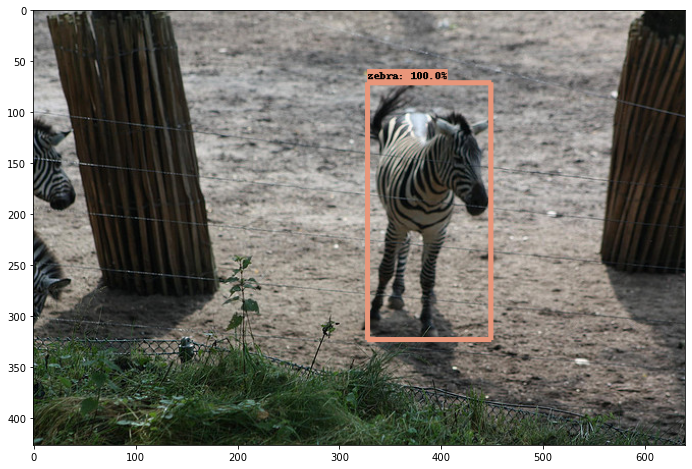

In [10]:
detect(detection_graph, '/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000080.jpg')

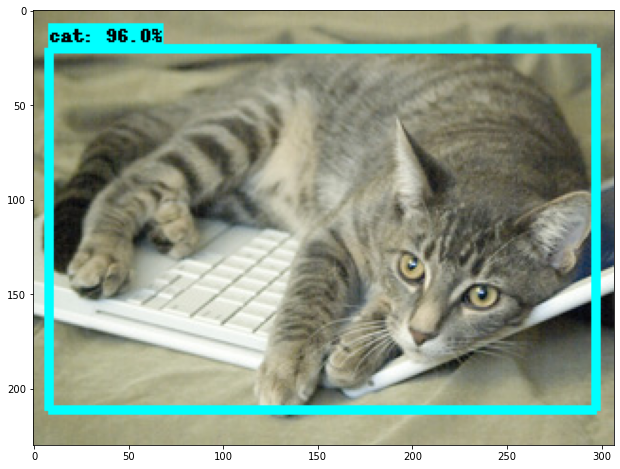

In [11]:
detect(detection_graph, '/kaggle/input/coco-2017-dataset/coco2017/test2017/000000001024.jpg')

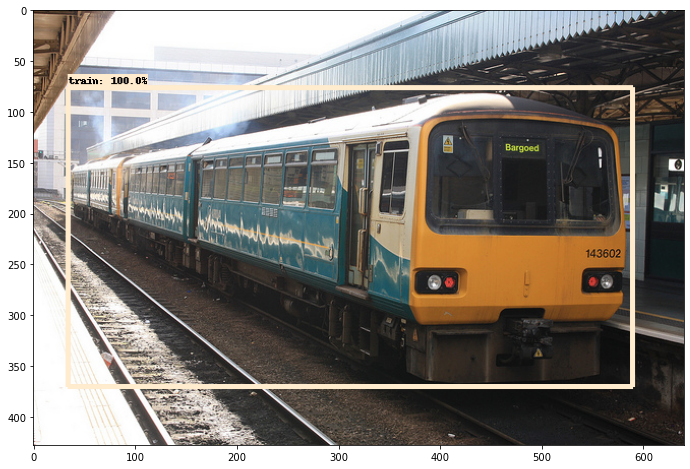

In [12]:
detect(detection_graph, '/kaggle/input/coco-2017-dataset/coco2017/test2017/000000002219.jpg')

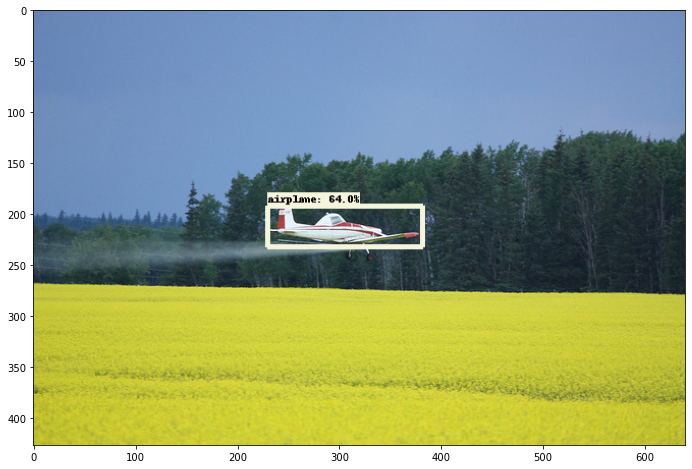

In [13]:
detect(detection_graph, '/kaggle/input/coco-2017-dataset/coco2017/test2017/000000002680.jpg')

# Cleanup

In [14]:
! rm -rf ./models